In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_data, get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim


## Choose Devices

In [2]:
gpu_id = 1
num_cores = 4

In [3]:
torch.cuda.set_device(gpu_id)

To load the patch critic, loading data is necessary. Is there a way to load the model without loading any data (can we save a good critic not as .pth file but as something else)?

# Model

## Initialization

In [6]:
nb_name = 'featureloss-resnet34-mse-baseline'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_path = data_pth/f'EM/models/feat_loss/'

# helper func
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)

# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)

In [7]:
superres_metrics = [F.mse_loss, psnr, ssim]

In [8]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(db, arch, wd=wd, 
#                          loss_func=feat_loss,
                         loss_func=F.mse_loss,
                         metrics=superres_metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_path)
gc.collect()

0

In [9]:
learn.model_dir = model_path
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/feat_loss


## Load Model (optional)

In [10]:
# learn.model_dir = model_pth
learn = learn.load(f'emsynth_005_unet.5')

## Training

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


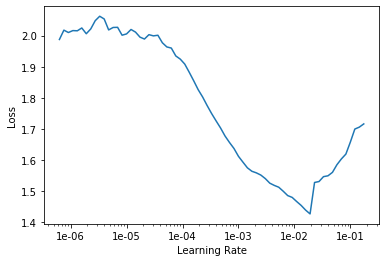

In [19]:
learn.recorder.plot()

### 1a

In [11]:
lr = 2e-4
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

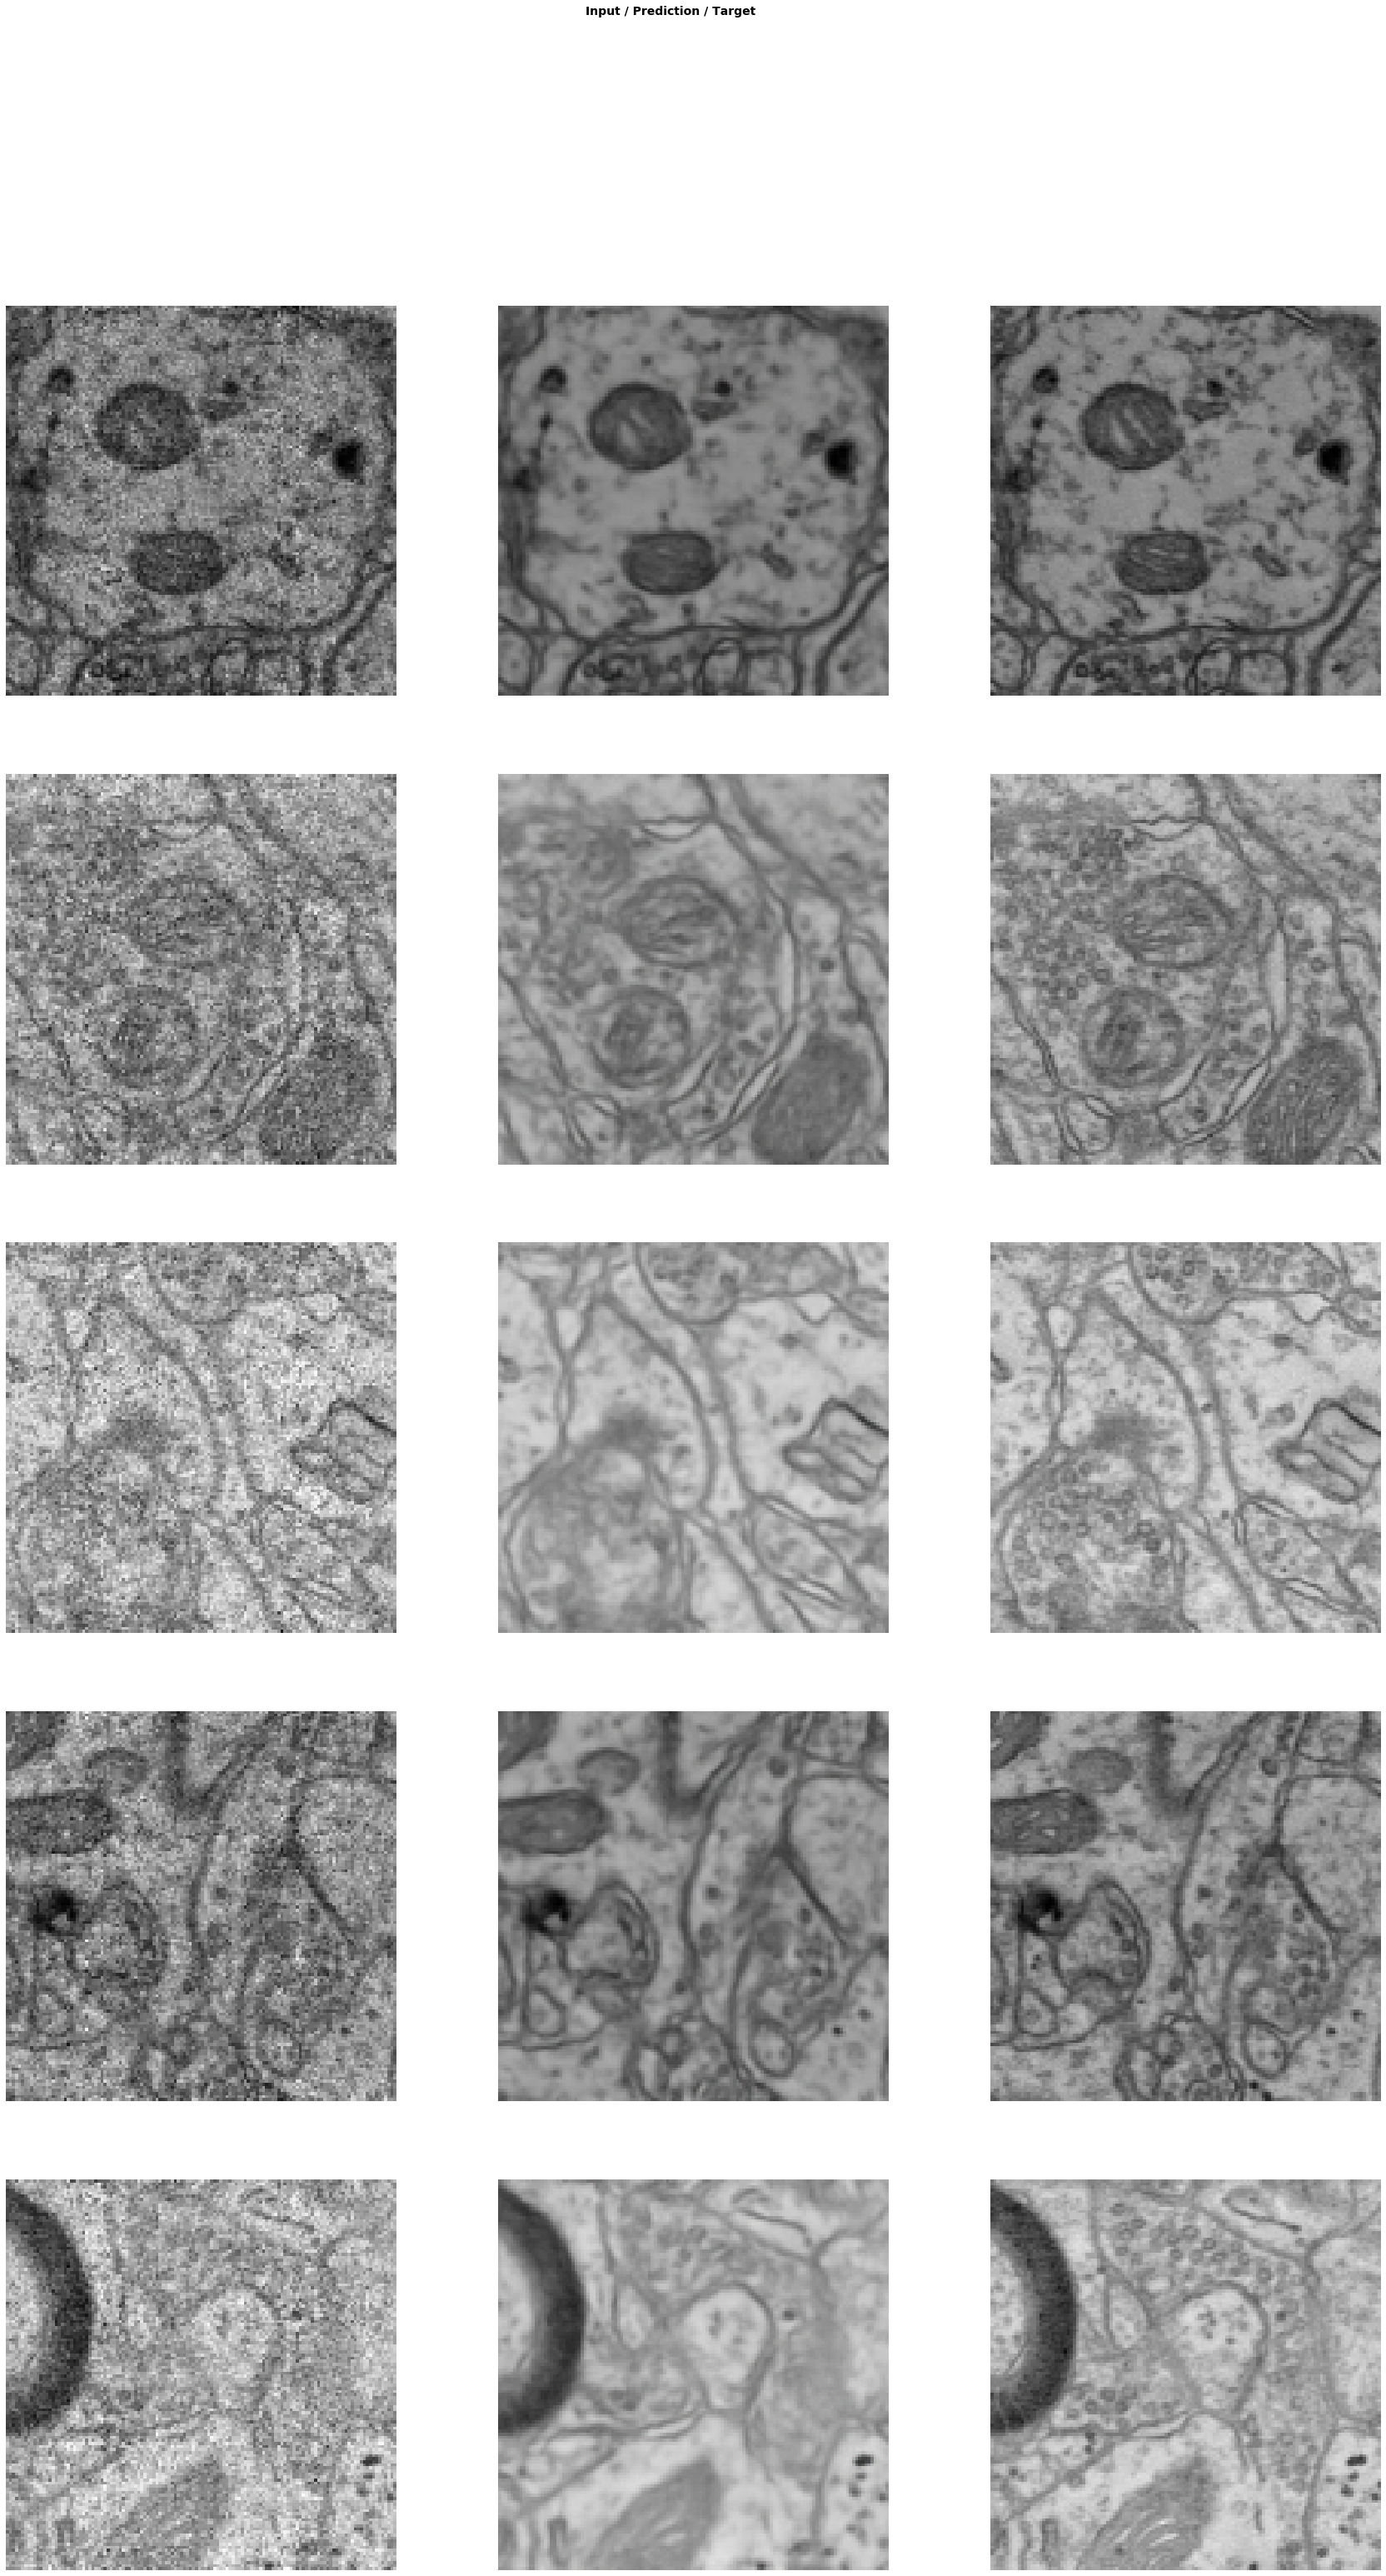

In [12]:
learn.show_results(rows=5, figsize=(30,50))

In [28]:
len(learn.data.valid_dl)

313

### 1b

In [13]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


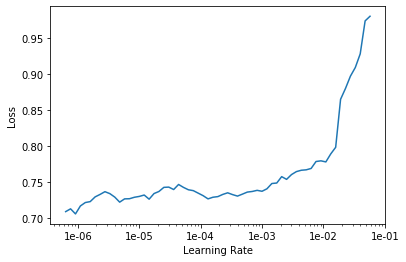

In [35]:
learn.recorder.plot()

In [14]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

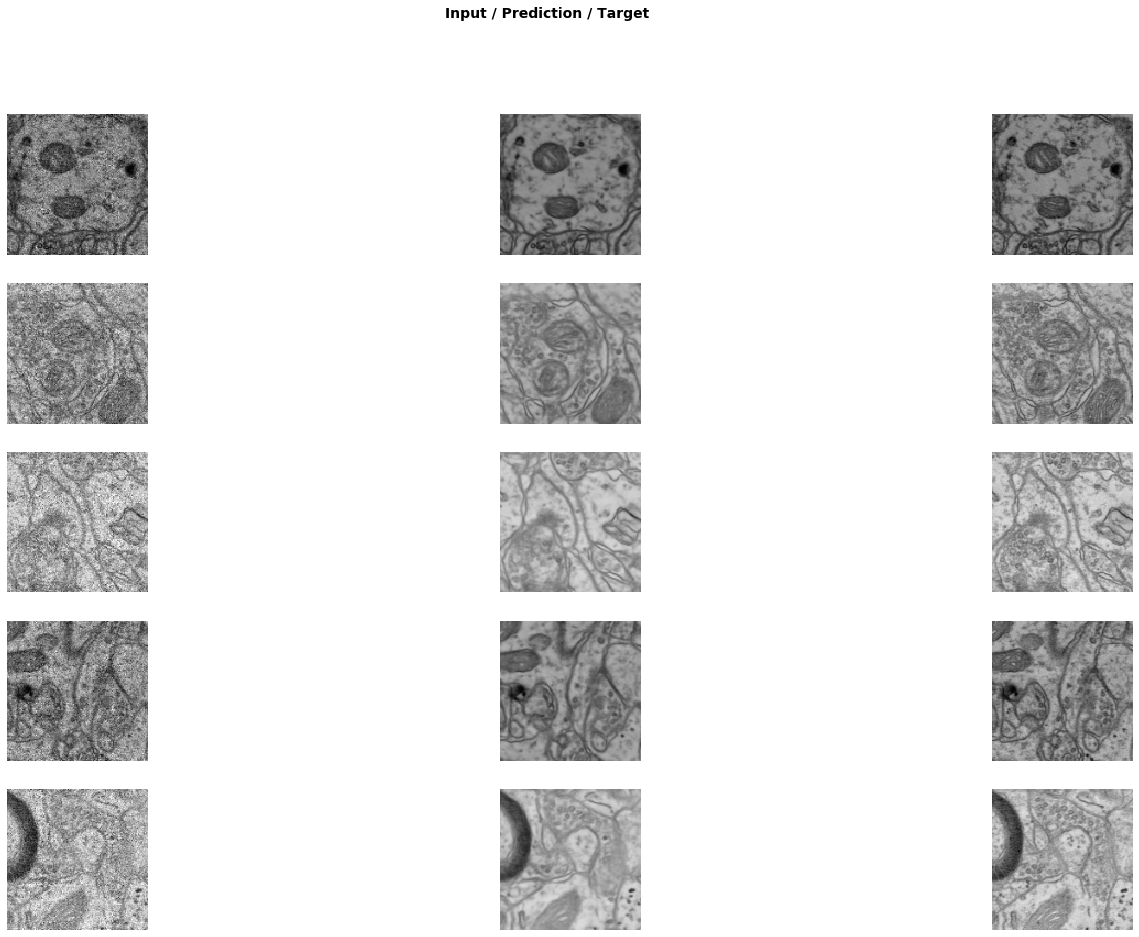

In [15]:
learn.show_results(rows=5, figsize=(25, 15))

## 2a

In [16]:
# loading 3 rounds of data
bs_2 = 32
size_2 = 256
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_2, in_sz=size_2, out_sz=size_2, max_zoom=3)

In [17]:
learn.data = db

In [18]:
learn.freeze()

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


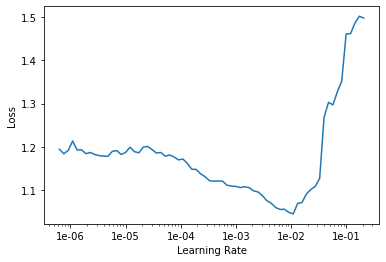

In [46]:
learn.recorder.plot()

In [19]:
lr = 3e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.2a', with_opt=False)

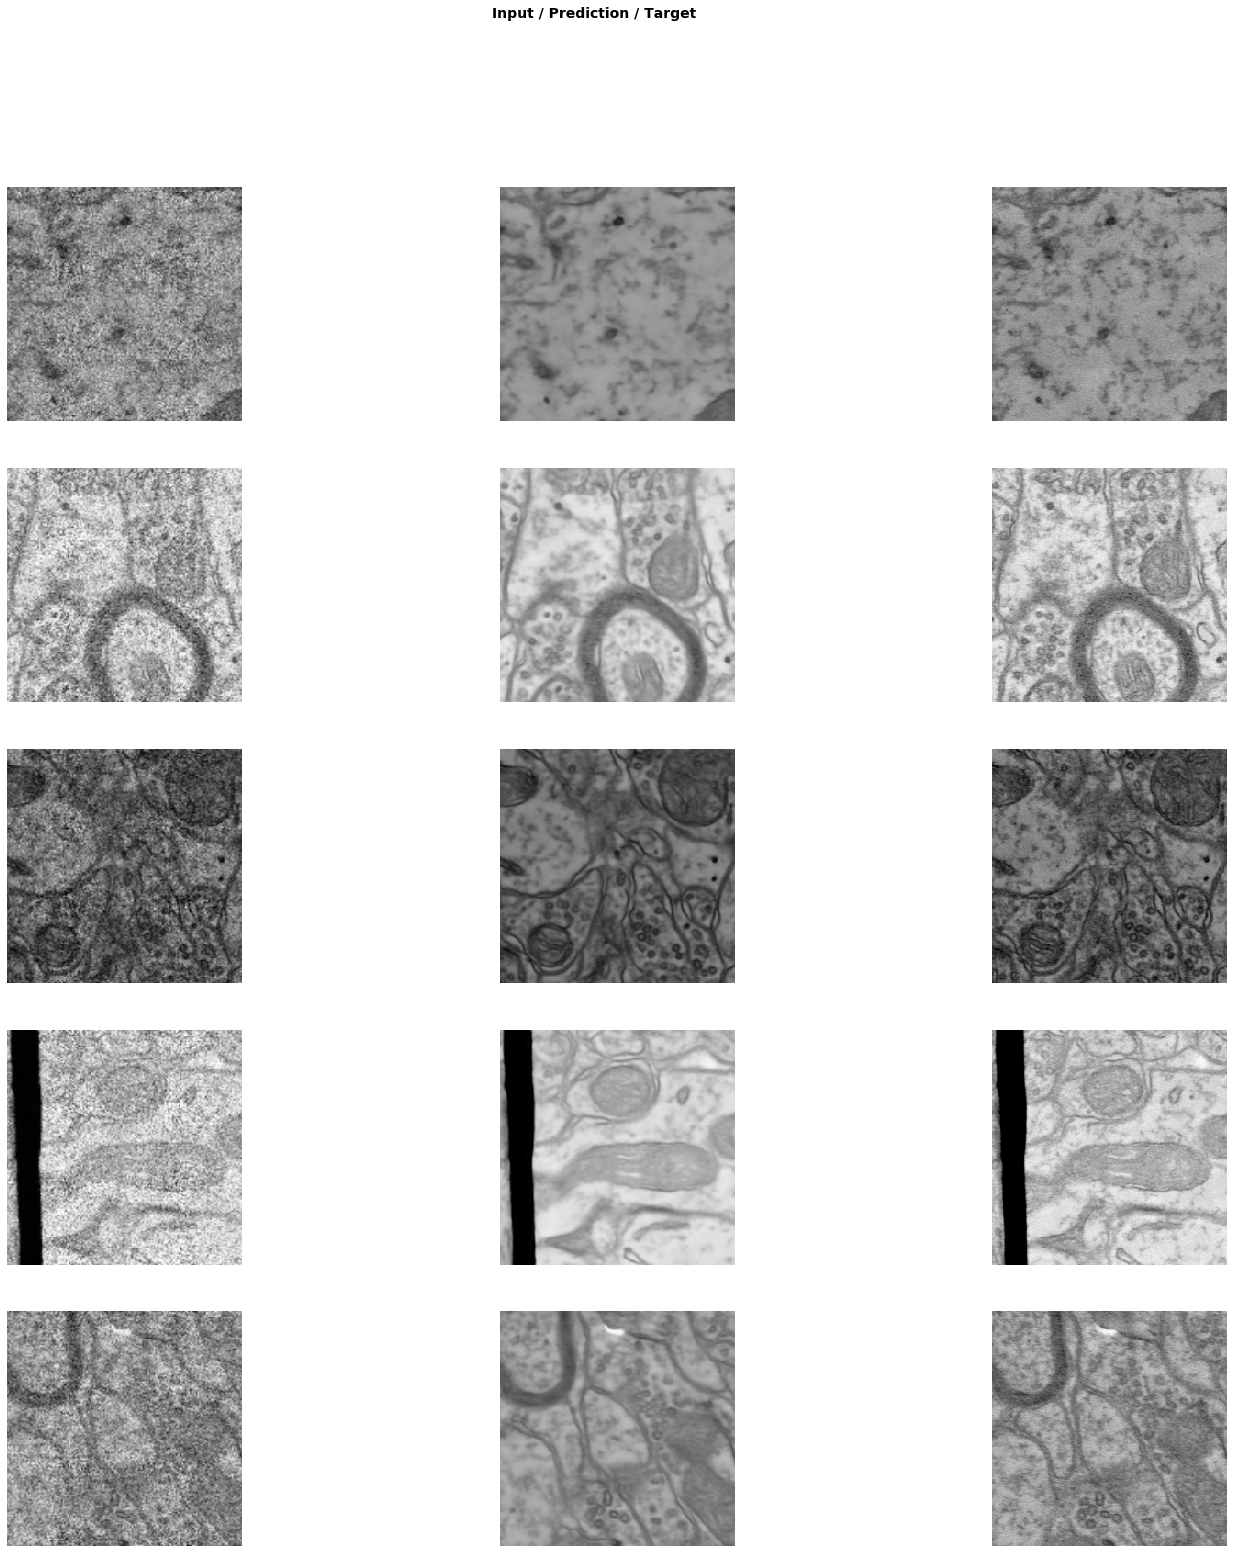

In [20]:
learn.show_results(rows=5, figsize=(25, 25))

## 2b

In [21]:
learn.unfreeze()

In [22]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2b', with_opt=False)

In [18]:
learn = learn.load(f'{nb_name}.2b');
learn.validate()

[0.4595427, tensor(0.0450), tensor(21.8443), tensor(0.6406)]

In [20]:
learn.load(f"emsynth_005_unet.5");
learn.validate()

[1.6133391, tensor(0.0591), tensor(20.6605), tensor(0.4628)]

## 3a

In [23]:
# loading 3 rounds of data
bs_3 = 8
size_3 = 512
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_3, in_sz=size_3, out_sz=size_3, max_zoom=2.)

In [24]:
learn.data = db
learn.data

ImageDataBunch;

Train: LabelList (79998 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Valid: LabelList (19999 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Test: None

In [25]:
learn.freeze()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


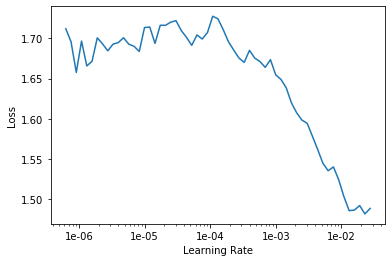

In [28]:
learn.recorder.plot()

In [26]:
lr = 1e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.3a', with_opt=False)

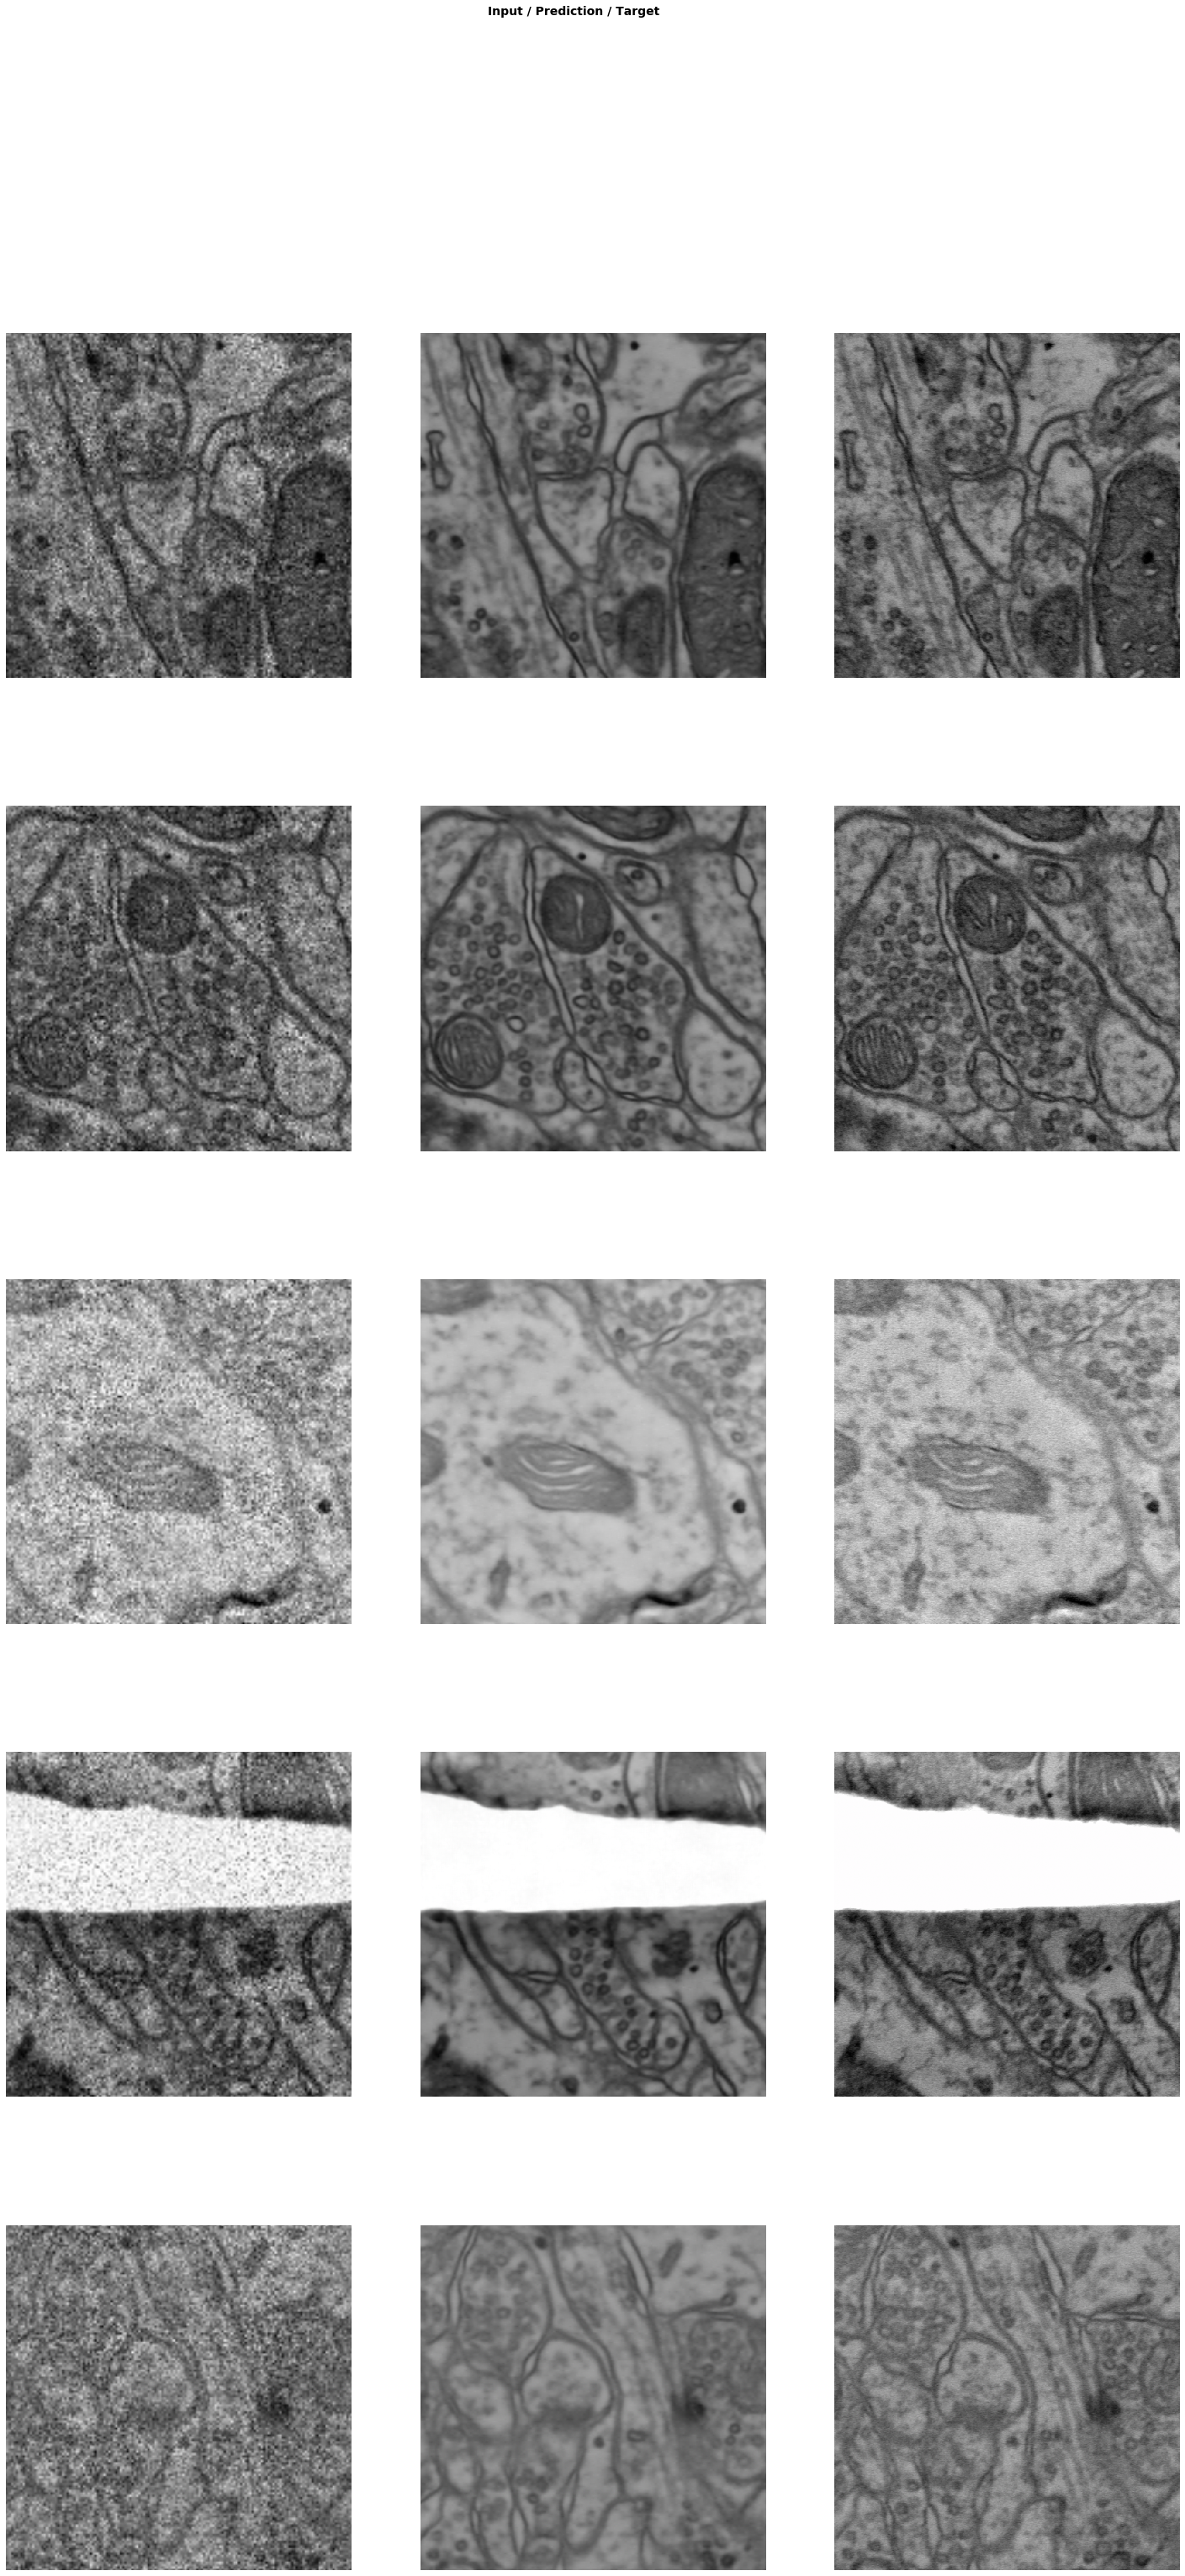

In [27]:
learn.show_results(rows=5, figsize=(25, int(25*2)))

In [28]:
learn.unfreeze()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


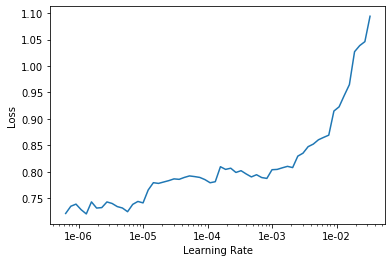

In [36]:
learn.recorder.plot()

In [29]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3b', with_opt=False)

In [ ]:
learn.show_results(5, figsize=(25, 50))

In [ ]:
def patchwise_mse(target, predict, coords):
    num_patches = coords.shape[0]
    for xys in coords:
        loss += mse(predict[xys[0]:xys[1], xys[2]:xys[3]])
    return loss / num_patches